In [ ]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


item_1 = pd.read_csv('item_properties_part1.csv', sep = ',')
categ = pd.read_csv('category_tree.csv', sep = ',')
item_2 = pd.read_csv('item_properties_part2.csv', sep = ',')
events = pd.read_csv('events.csv', sep = ',')
items = pd.concat([item_1, item_2])

events.head()


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


**1. Analysons les proportions d'occurrence des différents "events"**

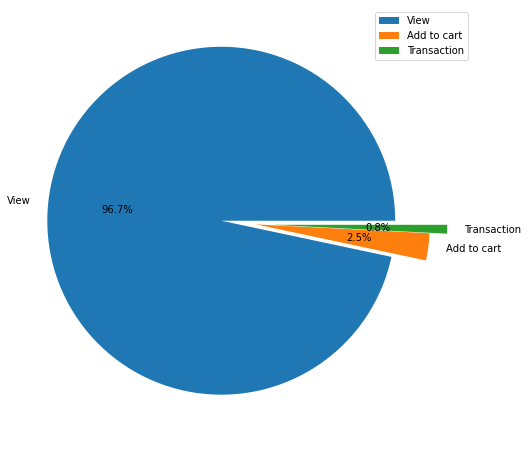

In [ ]:

plt.subplots(figsize=(8,8))
plt.pie(events.event.value_counts(),
        labels= ['View', 'Add to cart', 'Transaction'],
        autopct= lambda x: str(round(x,1)) + '%',
        explode = (0.2, 0, 0.1))
plt.legend();


Nous constatons que l'event "View" est prépondérant avec 96.7% des events de la base. Le tunnel de conversion d'un achat est View --> Add to cart --> Transactions.
Voyons ce qui se passe entre ces 3 actions.

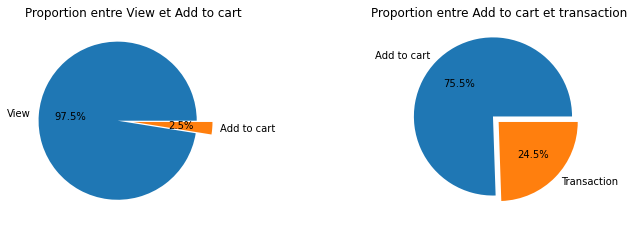

In [ ]:
conv_cart = events[(events['event']=='view') | (events['event']=='addtocart')]
conv_transaction = events[(events['event']=='transaction') | (events['event']=='addtocart')]

fig = plt.figure(figsize = (12,8))

plt.subplot(221)
plt.pie(conv_cart.event.value_counts(),
        labels= ['View', 'Add to cart'],
        autopct= lambda x: str(round(x,1)) + '%',
        explode = (0.2, 0, ))
plt.title('Proportion entre View et Add to cart')

plt.subplot(222)
plt.pie(conv_transaction.event.value_counts(),
        labels= ['Add to cart', 'Transaction'],
        autopct= lambda x: str(round(x,1)) + '%',
        explode = (0.1, 0))
plt.title('Proportion entre Add to cart et transaction');


On constate que seul 2.5% des vues sont converties en ajout au panier, et la conversion de mise en panier en acte d'achat se produit dans 24.5% des cas.
Par la suite, il pourrait être intéressant d'étudier les raisons du faible taux de conversion entre View et Add to cart (par exemple la non disponibilité des produits?


**2. Comportement des visiteurs selon les events**

In [ ]:
Nb_visiteurs = len(events.visitorid)
print('Nombre de visites: ', Nb_visiteurs)

Nb_visiteurs_uniques = events.visitorid.nunique()
print('Nombre de visteurs unique: ', Nb_visiteurs_uniques)

visiteurs_acheteurs = events[events.transactionid.notnull()].visitorid.nunique()
print('Nombre acheteurs unique:', visiteurs_acheteurs)

Ratio = (visiteurs_acheteurs/Nb_visiteurs_uniques)*100
print(str(round(Ratio,2)), '% des visteurs ont fait au moins une transaction.')

Nombre de visites:  2756101
Nombre de visteurs unique:  1407580
Nombre acheteurs unique: 11719
0.83 % des visteurs ont fait au moins une transaction.


La proportion très faible de visiteurs qui effectue un achat nous amènera à analyser si un nombre de visteurs anormaux n'affectent pas la base.

In [ ]:
Nb_transaction = events.transactionid.nunique()
Ratio2 = Nb_transaction/visiteurs_acheteurs
print('Les acheteurs font en moyenne', str(round(Ratio2,2)), 'transactions')

Les acheteurs font en moyenne 1.51 transactions


**3. Analysons plus en détail les comportements d'achat des acheteurs selon le nombre de transactions qu'ils effectuent**

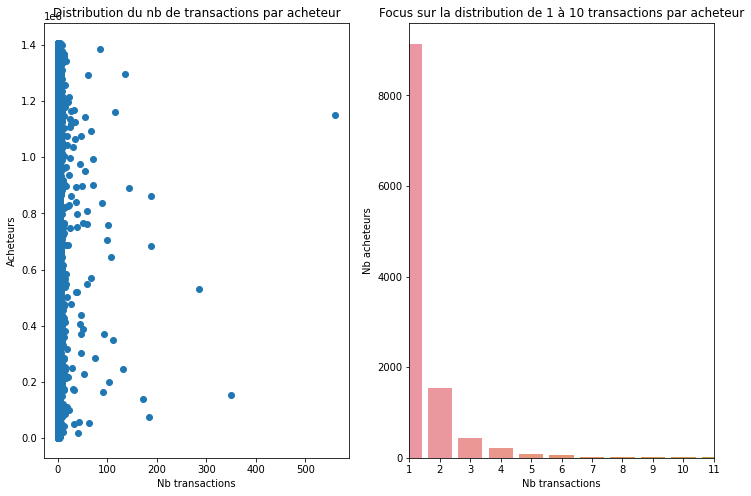

In [ ]:

events2 = events.dropna(axis=0, how='all', subset=['transactionid'])
events2 = events2.groupby('visitorid').agg({'transactionid':'count'}).sort_values(by='transactionid')
events2 = events2.reset_index()

fig = plt.figure(figsize = (12,8))
plt.subplot(121)
plt.scatter(x=events2.transactionid, y=events2.visitorid)
plt.xlabel('Nb transactions')
plt.ylabel('Acheteurs')
plt.title('Distribution du nb de transactions par acheteur')


plt.subplot(122)
sns.countplot(x=events2.transactionid)
plt.xlim(0,10)
plt.xlabel('Nb transactions')
plt.ylabel('Nb acheteurs')
plt.title('Focus sur la distribution de 1 à 10 transactions par acheteur');

On constate que le nombre de transactions par acheteur est faible. Le focus sur la distribution des visiteurs ayant fait entre 1 et 10 transactions nous confirme que le nombre de transaction est majoritairement de 1 et 2 transactions.


In [ ]:

acheteur_item = events2[events2['transactionid'] <= 2 ].visitorid.count()
Ratio = acheteur_item/visiteurs_acheteurs*100
print('Nombre acheteurs qui ont fait 1 à 2 transactions :', acheteur_item, ', Ce qui correspond à ', str(round(Ratio,0)), '% des acheteurs.')


Nombre acheteurs qui ont fait 1 à 2 transactions : 10692 , Ce qui correspond à  91.0 % des acheteurs.


**4. Analysons combien de produits en moyenne sont achetés lors des transactions**

In [ ]:
events3 = events.dropna(axis=0, how='all', subset=['transactionid'])
events3 = events3.groupby('transactionid').agg({'itemid':'count'}).sort_values(by='itemid')
events3 = events3.reset_index()
events3.describe()


,transactionid,itemid
count,17672.000000,17672.000000
mean,8835.500000,1.270767
std,5101.611314,0.974793
min,0.000000,1.000000
25%,4417.750000,1.000000
50%,8835.500000,1.000000
75%,13253.250000,1.000000
max,17671.000000,31.000000


No handles with labels found to put in legend.


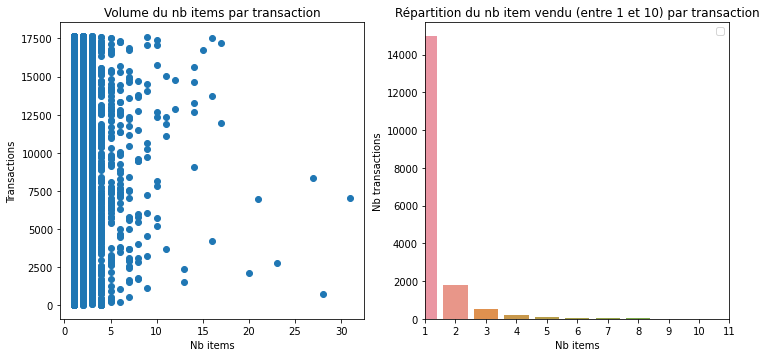

In [ ]:
fig = plt.figure(figsize = (12,12))
plt.subplot(221)
plt.scatter(x=events3.itemid, y=events3.transactionid)
plt.xlabel ('Nb items')
plt.ylabel ('Transactions')
plt.title('Volume du nb items par transaction')

plt.subplot(222)
sns.countplot(x=events3.itemid)
plt.xlim(0,10)
plt.xlabel('Nb items')
plt.ylabel('Nb transactions')
plt.title('Répartition du nb item vendu (entre 1 et 10) par transaction')
plt.legend();


De nouveau, le nombre d'items le plus souvent commandés par transaction se concentre entre 1 et 2 items. 

In [ ]:
transaction_item = events3[events3['itemid'] <= 2 ].transactionid.count()
Ratio2 = transaction_item/Nb_transaction*100
print('Nombre transactions qui intègre 1 à 2 items :', transaction_item, ', ce qui correspond à ', str(round(Ratio,0)), '% des transactions.')

Nombre transactions qui intègre 1 à 2 items : 16756 , ce qui correspond à  91.0 % des transactions.


Cette première exploration des données concernant les transactions indique que les acheteurs ont majoritairement fait 1 à 2 transactions durant la période et que ces transactions intègrent le plus souvent 1 à 2 items.

Autres explorations possible:
- analyse des catégories pour voir si certaines catégories sont plus vendeuses que d'autres


**5. Analysons les comportements visiteurs selon les dates**

In [ ]:
times = []
for i in events['timestamp']:
  times.append(datetime.datetime.fromtimestamp(i//1000.0))
events['timestamp'] = times
events.head()

In [ ]:
events['day'] = pd.to_datetime(events['timestamp']).dt.weekday
events['month'] = pd.to_datetime(events['timestamp']).dt.month
events['date'] = pd.to_datetime(events['timestamp']).dt.date
events.head()


,timestamp,visitorid,event,itemid,transactionid,day,month,date
0,2015-06-02 05:02:12,257597,view,355908,NaN,1,6,2015-06-02
1,2015-06-02 05:50:14,992329,view,248676,NaN,1,6,2015-06-02
2,2015-06-02 05:13:19,111016,view,318965,NaN,1,6,2015-06-02
3,2015-06-02 05:12:35,483717,view,253185,NaN,1,6,2015-06-02
4,2015-06-02 05:02:17,951259,view,367447,NaN,1,6,2015-06-02


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


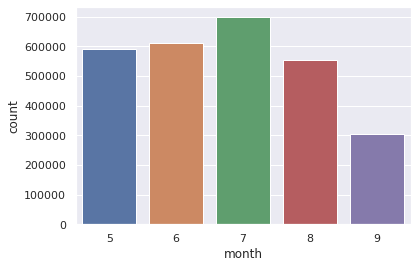

In [ ]:
sns.set_theme()
sns.countplot("month",data=events);

Comme prévu, les données sont sur 4.5 mois entre mai et mi-septembre. Le mois de juillet est celui qui a plus d'event. Sachant que le nombre de de View est prépondérant dans la base, vérifions si cette répartition change selon le type d'event.

No handles with labels found to put in legend.


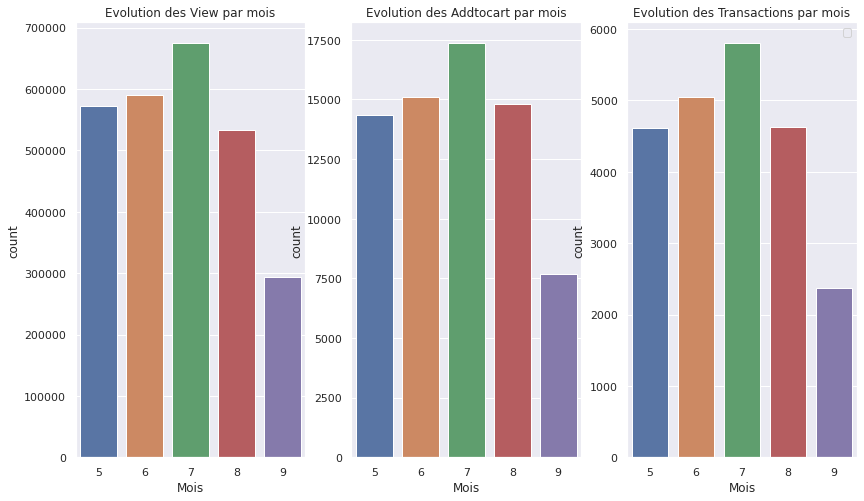

In [ ]:
transaction = events[events['event']=='transaction']
view = events[events['event']=='view']
addtocart = events[events['event']=='addtocart']

fig = plt.figure(figsize = (14,8))
plt.subplot(131)
sns.countplot(x = view['month'])
plt.xlabel('Mois')
plt.title("Evolution des View par mois")

plt.subplot(132)
sns.countplot(x = addtocart['month'])
plt.xlabel('Mois')
plt.title("Evolution des Addtocart par mois")

plt.subplot(133)
sns.countplot(x = transaction['month'])
plt.xlabel('Mois')
plt.title("Evolution des Transactions par mois")
plt.legend();


Les 3 events suivent les mêmes tendances mensuellement.
Analysons maintenant les tendances selon les jours de la semaine.

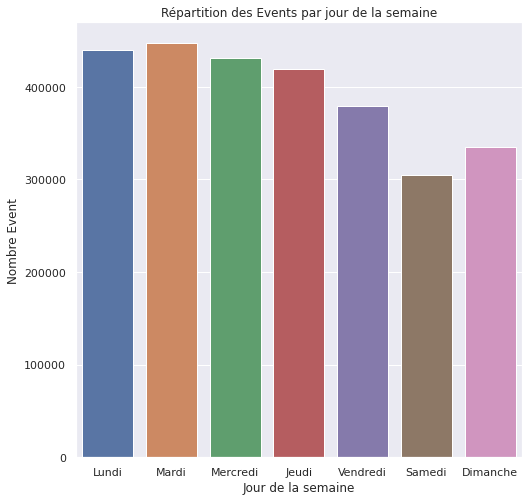

In [ ]:
plt.figure(figsize = (8,8))
sns.countplot(x = events['day'])
plt.xticks(np.arange(7),['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre Event')
plt.title('Répartition des Events par jour de la semaine');

Le traffic est plus élevé les jours ouvrés que les week-end. Voyons si la tendance entre les 3 events est la même.

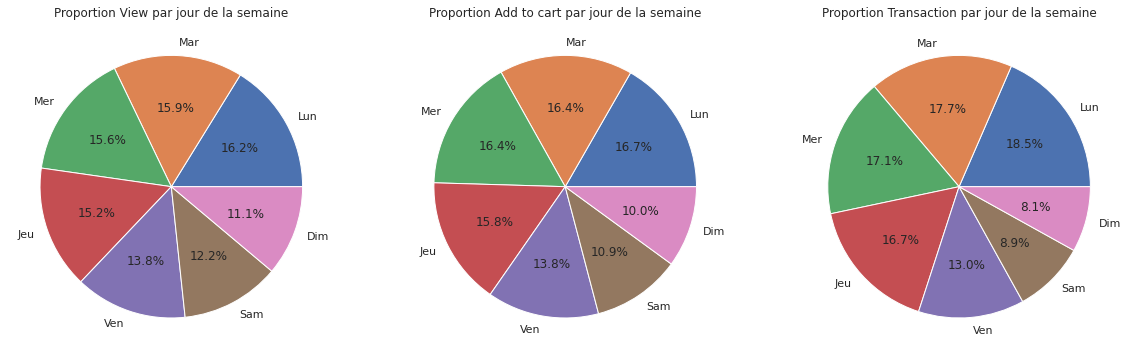

In [ ]:
fig = plt.figure(figsize = (20,10))

plt.subplot(131)
plt.pie(view.day.value_counts(),
        labels= ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'],
        autopct= lambda x: str(round(x,1)) + '%')
plt.title("Proportion View par jour de la semaine")

plt.subplot(132)
plt.pie(addtocart.day.value_counts(),
        labels= ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'],
        autopct= lambda x: str(round(x,1)) + '%')
plt.title("Proportion Add to cart par jour de la semaine")

plt.subplot(133)
plt.pie(transaction.day.value_counts(),
        labels= ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'],
        autopct= lambda x: str(round(x,1)) + '%')
plt.title("Proportion Transaction par jour de la semaine");

De nouveau, on s'aperçoit que les 3 types d'Events suivent la même tendance selon les jours de la semaine.

**6. Déterminons les meilleurs clients du site**

Durant les 4.5 mois, les 11 719 clients uniques ont acheté 1,2 voir plusieurs articles sur le site. Déterminons quels sont les 10 meilleurs clients.

In [ ]:
group_clients_transac = transaction.groupby('visitorid').agg({'transactionid' : 'count'}).sort_values(by ='transactionid', ascending=False)
group_clients_transac

,transactionid
visitorid,
1150086,559
152963,349
530559,286
684514,189
861299,188
...,...
535433,1
535446,1
535618,1


Plus de 90% des clients de ce site ont acheté entre 1 ou 2 articles. Toutefois, on peut remarquer qu'il y en a qui ont commandé plus d'un centaine. Le meilleur client, facilement reparable, est celui à l'indice 1150086 qui a commandé 559 fois.Ces transactions sont croissantes selon le jour de la semaine avec des pics le mercredi et le jeudi puis décroissantes en fin de semaine. Ce client a acheté plus de 250 articles en juillet soit plus du double comparé aux autres mois.

In [ ]:
best_client = transaction[transaction['visitorid'] == 1150086].sort_values(by = 'timestamp')
best_client.head()

,timestamp,visitorid,event,itemid,transactionid,day,month,date
237133,2015-06-11 15:28:45,1150086,transaction,398115,7510.0,3,6,2015-06-11
230745,2015-06-11 15:42:28,1150086,transaction,375955,6495.0,3,6,2015-06-11
243864,2015-06-11 15:46:36,1150086,transaction,357133,5235.0,3,6,2015-06-11
236873,2015-06-11 21:42:58,1150086,transaction,310620,4070.0,3,6,2015-06-11
239981,2015-06-11 21:42:58,1150086,transaction,276704,4070.0,3,6,2015-06-11


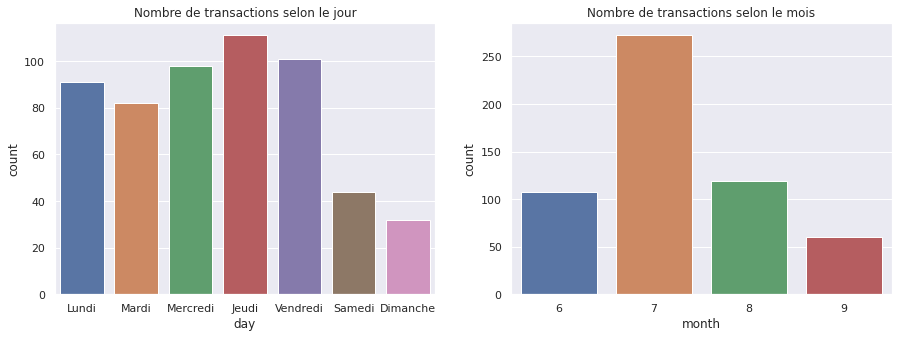

In [ ]:
fig = plt.figure(figsize=(15,5))                  

plt.subplot(121)                                    
sns.countplot(x ='day', data= best_client)
#plt.ylim([200000,800000])
plt.xticks([0,1,2,3,4,5,6], ['Lundi', 'Mardi','Mercredi','Jeudi','Vendredi', 'Samedi','Dimanche'])
plt.title("Nombre de transactions selon le jour")

plt.subplot(122)
sns.countplot(x ='month', data= best_client)
#plt.ylim([200000,800000])
#plt.xticks([6,7,8,9], ['Juin','Juillet','Aout','Septembre'])
plt.title("Nombre de transactions selon le mois")
plt.show();

**7. Les articles les plus commandés par les clients**

Intéressons-nous maintenant aux articles qui ont été commandés sur le site. 
On dénombre 12 025 articles uniques qui ont été achetés au cours de la période.

In [ ]:
transaction['itemid'].nunique()

12025

In [ ]:
group_items = transaction.groupby('itemid').agg({'itemid': 'count'})
group_items = group_items.rename(columns = {'itemid':'Total_purchased'})

#Les dix articles les plus achetés par les clients
top_ten_purchased = group_items.sort_values(by = 'Total_purchased', ascending = False).head(10)
top_ten_purchased = top_ten_purchased.rename_axis('itemid').reset_index()
top_ten_purchased

,itemid,Total_purchased
0,461686,133
1,119736,97
2,213834,92
3,312728,46
4,7943,46
5,445351,45
6,48030,41
7,420960,38
8,248455,38
9,17478,37


<Figure size 576x432 with 0 Axes>

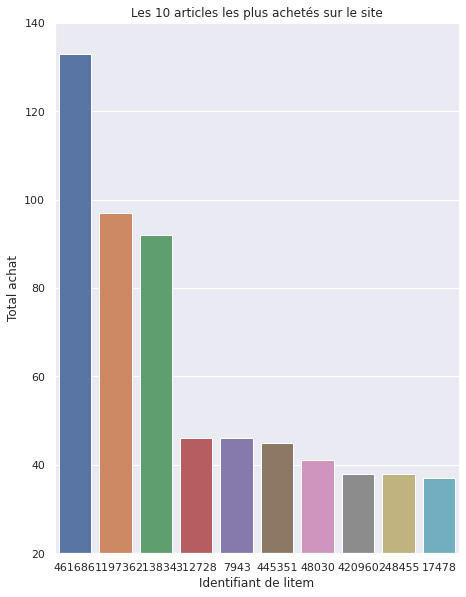

In [ ]:
top_ten_purchased['itemid'] = top_ten_purchased['itemid'].astype(str)

sns.set_theme()
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8,6))
sns.catplot(x="itemid", y="Total_purchased", kind="bar", data=top_ten_purchased, height=8, aspect=.8)
plt.ylim([20,140])
plt.xlabel('Identifiant de l''item');
plt.ylabel('Total achat');
plt.title('Les 10 articles les plus achetés sur le site');

**8. Analyse de corrélation**

Finalement la matrice de corrélation entre les variables ne laisse présager d'aucun lien de dépendance entre elles. Elles sont donc non-corrélées.

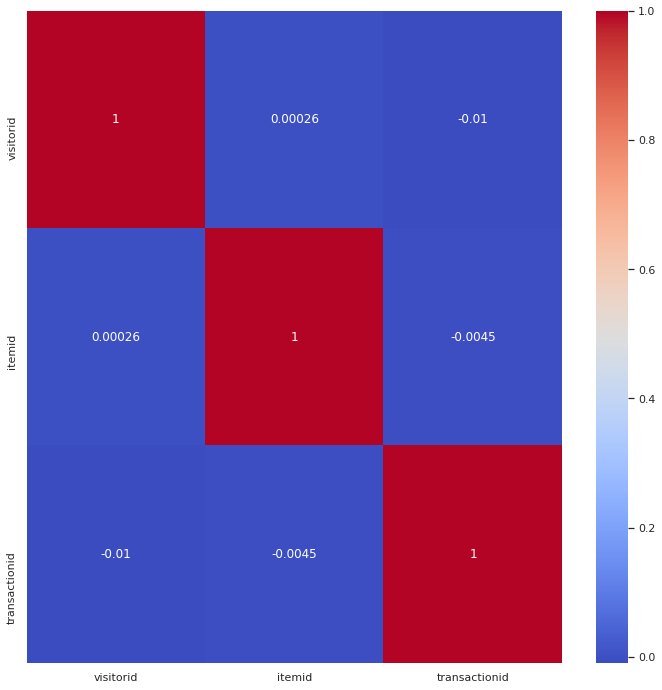

In [ ]:
#Matrice des corrélations
events_corr = events.drop(columns = ['timestamp','day','month','date'])

cor = events_corr.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot= True, ax= ax,cmap="coolwarm");